In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#### IMPORT LIBRARIES
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
import os
from os.path import exists
from numba import cuda
import warnings
import tensorflow as tf
import cv2
from PIL import Image
import torchvision.transforms

import torch
from torch import nn, optim
import torch.nn.functional as functional
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image

!pip install albumentations==0.4.6
import albumentations 
from albumentations.pytorch import ToTensorV2

!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

     |████████████████████████████████| 117 kB 5.1 MB/s 
     |████████████████████████████████| 948 kB 47.1 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65174 sha256=e2e6155f489bb622281278547b3483807b4b17ffbad49ae53a36e999a69f0160
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=c29d993163e549d327b2aaf6aa36f89ca752b1b4bd01e08e1c9bc4cde9a0996e
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74

Text(0.5, 0, 'Diagnosis Level')

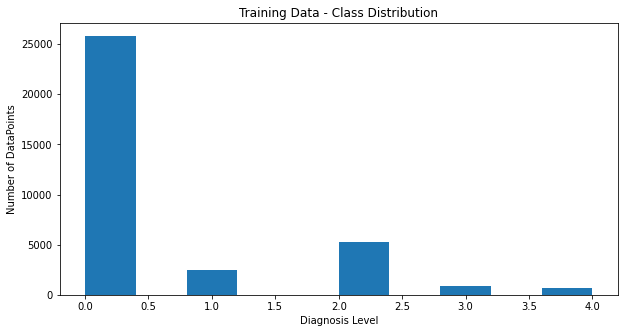

In [ ]:
#### Diagnosis LEVEL-WISE - Training Data Class Distribution
train  = pd.read_csv('/content/drive/MyDrive/diabetic-retinopathy/2015_resized/trainLabels.csv')
validation = pd.read_csv('/content/drive/MyDrive/diabetic-retinopathy/aptos_resized_150x150/train.csv')

fig = plt.figure(figsize = (10, 5))
plt.hist(train['level'])
plt.title('Training Data - Class Distribution')
plt.ylabel('Number of DataPoints')
plt.xlabel('Diagnosis Level')

In [ ]:
#### Distribution of Training Data according to Level of Diabetic Retinopathy
print("Total Number of Training DataPoints :"+str(train.shape[0]))
print('-' * 16)
print(train['level'].value_counts())
print('-' * 16)
print("Total Number of Validation DataPoints :"+str(validation.shape[0]))


Total Number of Training DataPoints :35126
----------------
0    25810
2     5292
1     2443
3      873
4      708
Name: level, dtype: int64
----------------
Total Number of Validation DataPoints :3662


In [ ]:
class Dataset_Function(Dataset):
    def __init__(self, directory, csv_file_loc, train=True, transform=None):
        super().__init__()
        self.data = pd.read_csv(csv_file_loc)
        self.directory = directory
        self.image_files = os.listdir(directory)
        self.transform = transform
        self.train = train

    def __len__(self):
        return self.data.shape[0] if self.train else len(self.image_files)

    def __getitem__(self, index):
        if self.train:
            image_file, label = self.data.iloc[index]
        else:
            image_file, label = self.image_files[index], -1
            image_file = image_file.replace(".png", "")
            image_file = image_file.replace(".jpeg", "")
        if exists(os.path.join(self.directory, image_file+".png")):
          image = np.array(Image.open(os.path.join(self.directory, image_file+".png")))
        elif exists(os.path.join(self.directory, image_file+".jpeg")):
          image = np.array(Image.open(os.path.join(self.directory, image_file+".jpeg")))
        if self.transform:
            image = self.transform(image=image)["image"]

        return image, label, image_file





In [ ]:
#CONFIGURATIONS FOR MODEL


NUM_WORKERS = 1
BATCH_SIZE = 20
NUM_EPOCHS = 1
WEIGHT_DECAY = 5e-4
LEARNING_RATE = 3e-5

CHECKPOINT_FILE = "/content/drive/MyDrive/b.pth.tar"

image_size = 150

PIN_MEMORY = True

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


# augs = albumentations.Compose([albumentations.Resize(height = image_size, 
#                            width  = image_size),
#                   albumentations.Normalize(mean = (0, 0, 0),
#                               std  = (1, 1, 1)),
#                   ToTensorV2()])


# image_dataset= Dataset_Function(csv_file_loc = "/content/drive/MyDrive/2015_resized/trainLabels.csv", 
#                          directory = "/content/drive/MyDrive/2015_resized/train_resized_150",
#                          transform = augs)
# image_loader = DataLoader(image_dataset, 
#                           batch_size  = BATCH_SIZE, 
#                           shuffle     = False, 
#                           num_workers = NUM_WORKERS,
#                           pin_memory  = PIN_MEMORY)


# psum    = torch.tensor([0.0, 0.0, 0.0])
# psum_sq = torch.tensor([0.0, 0.0, 0.0])

# for input in tqdm(image_loader):
#   psum += torch.sum(input,dim =[0, 2, 3])
#   psum_sq += torch.sum((input ** 2), dim = [0, 2, 3])

# count = len(train) * image_size * image_size

# total_mean = psum / count
# total_var  = (psum_sq / count) - (total_mean ** 2)
# total_std  = torch.sqrt(total_var)

# Data augmentation for images

#we get mean as [0.3753, 0.2609, 0.1866] and std as [0.2900, 0.2098, 0.1701] by running the above code on training dataset, to normalize.

train_transforms = albumentations.Compose(
    [
        albumentations.Resize(width=image_size, height=image_size),
        albumentations.RandomCrop(height=image_size, width=image_size),
        ToTensorV2(),
    ]
)

validation_transforms = albumentations.Compose(
    [
        albumentations.Resize(height=image_size, width=image_size),
        albumentations.Normalize(
            mean=[0.3753, 0.2609, 0.1866],
            std=[0.2900, 0.2098, 0.1701],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ]
)

In [ ]:
def prepare_image(path, sigmaX = 10, do_random_crop = False):
    
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    return image

def prepare_image_transformed(path, sigmaX = 10, do_random_crop = False):
    
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (int(image_size), int(image_size)))
    image = cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0, 0), sigmaX), -4, 128)
        
    return image

sample_transforms = albumentations.Compose([albumentations.Resize(height = image_size, 
                           width  = image_size),
                  ToTensorV2()])

class DatasetSample(Dataset):
    
    def __init__(self, data, directory, transform = None):
        self.data      = data
        self.directory = directory
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.directory, self.data.loc[idx, 'image'] + '.jpeg')
        img_name    = prepare_image(img_name)  
        transformed_image = self.transform(image=img_name)["image"]
        label    = torch.tensor(self.data.loc[idx, 'level'])
        return {'image': transformed_image, 'label': label}

class DatasetSample_transformed(Dataset):
    
    def __init__(self, data, directory, transform = None):
        self.data      = data
        self.directory = directory
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.directory, self.data.loc[idx, 'image'] + '.jpeg')
        img_name    = prepare_image_transformed(img_name)  
        transformed_image = self.transform(image=img_name)["image"]
        label    = torch.tensor(self.data.loc[idx, 'level'])
        return {'image': transformed_image, 'label': label}


sample_original_dataset = DatasetSample(data = pd.read_csv('/content/drive/MyDrive/Diabetic_Retinopathy/diabetic-retinopathy-detection/trainLabels.csv'), 
                         directory = "/content/drive/MyDrive/Diabetic_Retinopathy/diabetic-retinopathy-detection/train",
                         transform = sample_transforms)


sample_transformed_dataset = DatasetSample_transformed(data = pd.read_csv('/content/drive/MyDrive/2015_resized/trainLabels.csv'), 
                         directory = "/content/drive/MyDrive/2015_resized/train_resized_150",
                         transform = train_transforms)

sample_original_loader = DataLoader(sample_original_dataset, 
                          batch_size  = 10, 
                          shuffle     = False, 
                          num_workers = NUM_WORKERS,
                          pin_memory  = PIN_MEMORY)

sample_transformed_loader = DataLoader(sample_transformed_dataset, 
                          batch_size  = 10, 
                          shuffle     = False, 
                          num_workers = NUM_WORKERS,
                          pin_memory  = PIN_MEMORY)



/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


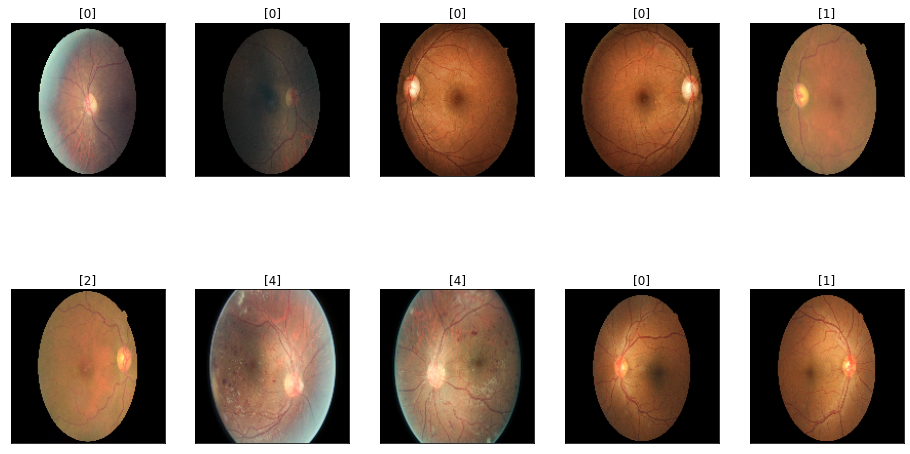

In [ ]:
for batch, data in enumerate(sample_original_loader):

    inputs = data['image']
    labels = data['label'].view(-1, 1)
    
    fig = plt.figure(figsize = (16, 9))
    for i in range(len(labels)):
        ax = fig.add_subplot(2, len(labels)/2, i + 1, xticks = [], yticks = [])     
        plt.imshow(inputs[i].numpy().transpose(1, 2, 0))
        ax.set_title(labels.numpy()[i])

    break

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


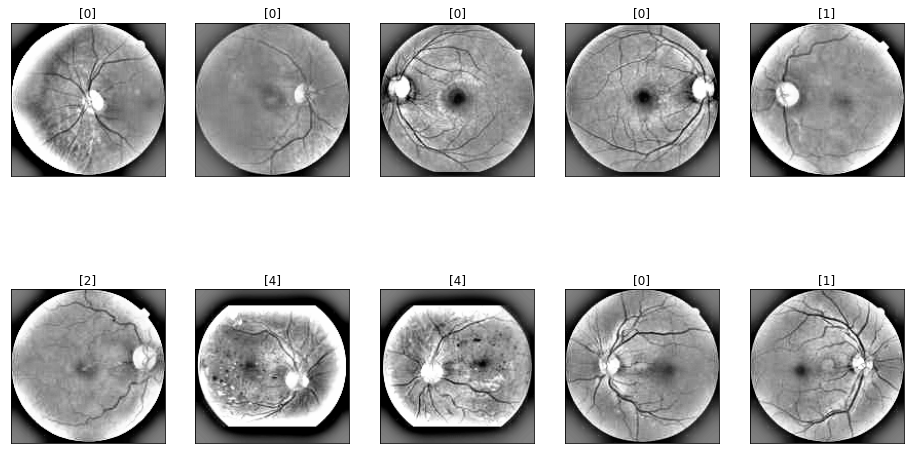

In [ ]:
for batch, data in enumerate(sample_transformed_loader):

    inputs = data['image']
    labels = data['label'].view(-1, 1)
    
    fig = plt.figure(figsize = (16, 9))
    for i in range(len(labels)):
        ax = fig.add_subplot(2, len(labels)/2, i + 1, xticks = [], yticks = []) 
        inputs[i] = torchvision.transforms.Grayscale()(inputs[i])
        plt.imshow(inputs[i].numpy().transpose(1, 2, 0))
        ax.set_title(labels.numpy()[i])

    break

In [ ]:
def accuracy_function(loader, model, device="cuda"):
    model.eval()
    list_preds, list_labels = [], []
    list_preds_new, list_labels_new = [], []
    num_correct = 0
    num_samples = 0
    num_correct_classes = 0
    num_samples_classes = 0

    for x, y, filename in tqdm(loader):
        x = x.to(device=device)
        y = y.to(device=device)

        with torch.no_grad():
            predictions = model(x)

        predictions_new = predictions.detach().clone() 
        predictions_new = predictions_new.long().view(-1)

        predictions[predictions < 0.5] = 0
        predictions[predictions >= 0.5] = 1

        predictions_new[predictions_new < 0.5] = 0
        predictions_new[(predictions_new >= 0.5) & (predictions_new < 1.5)] = 1
        predictions_new[(predictions_new >= 1.5) & (predictions_new < 2)] = 2
        predictions_new[(predictions_new >= 2) & (predictions_new < 3)] = 3
        predictions_new[(predictions_new >= 3)] = 4

        predictions = predictions.long().view(-1)
        y_new = y.detach().clone() 
        y_new = y_new.view(-1)

        y = y.view(-1)

        y[y < 1] = 0
        y[y >= 1] = 1

        num_correct_classes += (predictions_new == y_new ).sum()
        num_samples_classes += predictions_new.shape[0]
        
        num_correct += (predictions == y ).sum()
        num_samples += predictions.shape[0]

        list_labels.append(y.detach().cpu().numpy())
        list_preds.append(predictions.detach().cpu().numpy())

        list_labels_new.append(y_new.detach().cpu().numpy())
        list_preds_new.append(predictions_new.detach().cpu().numpy())


    print("For Diabetic Retinopathy Detection Accuracy:")
    print()
    print(f" {num_correct} / {num_samples} images were predicted correctly, with accuracy {float(num_correct) / float(num_samples) * 100:.2f}")
    print()
    confusion_matrix_detection = confusion_matrix(np.concatenate(list_labels, axis=0, dtype=np.int64), np.concatenate(
        list_preds, axis=0, dtype=np.int64))
    cmd = ConfusionMatrixDisplay(confusion_matrix_detection, display_labels=['Yes','No'])
    cmd.plot()
    plt.show()
    plt.savefig(f'{num_correct}.png')
    print("For Classwise Accuracy:")
    print()
    print(f"{num_correct_classes} / {num_samples_classes}  images were predicted correctly, with accuracy {float(num_correct_classes) / float(num_samples_classes) * 100:.2f}")
    print()
    confusion_matrix_classes = confusion_matrix(np.concatenate(list_labels_new, axis=0, dtype=np.int64), np.concatenate(
        list_preds_new, axis=0, dtype=np.int64))
    cmd = ConfusionMatrixDisplay(confusion_matrix_classes, display_labels=['0','1','2','3','4'])
    cmd.plot()
    plt.show()
    plt.savefig(f'{num_correct_classes}.png')
    model.train()
    return np.concatenate(list_preds, axis=0, dtype=np.int64), np.concatenate(
        list_labels, axis=0, dtype=np.int64)

In [ ]:

def epoch_wise_train_function(loader, model, optimizer, loss_fn, scaler, device):
    losses = []
    loop = tqdm(loader)
    for batch_idx, (data, targets, _) in enumerate(loop):
        data = data.to(device=device)
        targets = targets.to(device=device)
    
        with torch.cuda.amp.autocast():
            torch.cuda.memory_summary(device=None, abbreviated=False)
            scores = model(data)
            loss = loss_fn(scores, targets.unsqueeze(1).float())

        losses.append(loss.item())

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        loop.set_postfix(loss=loss.item())
        
    print(f"The Loss average over epoch is: {sum(losses)/len(losses)}")

Loaded pretrained weights for efficientnet-b2


100%|██████████| 1757/1757 [15:37<00:00,  1.87it/s, loss=0.339]


The Loss average over epoch is: 0.838584472698265


100%|██████████| 184/184 [13:45<00:00,  4.49s/it]


For Diabetic Retinopathy Detection Accuracy:

 3171 / 3662 images were predicted correctly, with accuracy 86.59



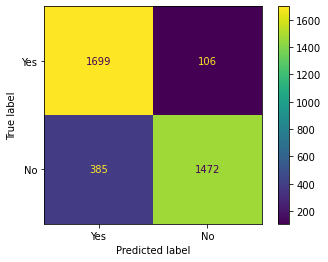

For Classwise Accuracy:

1929 / 3662  images were predicted correctly, with accuracy 52.68



<Figure size 432x288 with 0 Axes>

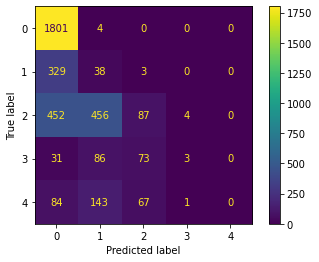

Results for efficientnet-b2




Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth


  0%|          | 0.00/47.1M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b3


100%|██████████| 1757/1757 [14:45<00:00,  1.98it/s, loss=0.177]


The Loss average over epoch is: 0.8364573361613937


100%|██████████| 184/184 [00:23<00:00,  7.69it/s]

For Diabetic Retinopathy Detection Accuracy:

 3210 / 3662 images were predicted correctly, with accuracy 87.66



<Figure size 432x288 with 0 Axes>

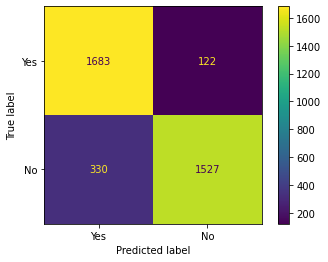

For Classwise Accuracy:

1955 / 3662  images were predicted correctly, with accuracy 53.39



<Figure size 432x288 with 0 Axes>

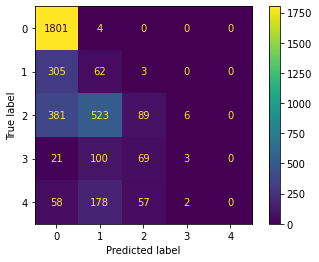

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth


  0%|          | 0.00/74.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b4


100%|██████████| 1757/1757 [19:18<00:00,  1.52it/s, loss=0.448]


The Loss average over epoch is: 0.8770358820971129


100%|██████████| 184/184 [00:30<00:00,  6.08it/s]

For Diabetic Retinopathy Detection Accuracy:

 3150 / 3662 images were predicted correctly, with accuracy 86.02



<Figure size 432x288 with 0 Axes>

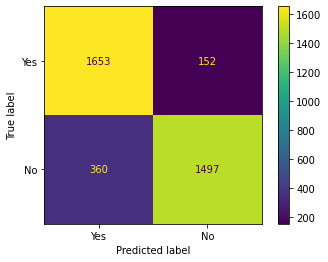

For Classwise Accuracy:

1883 / 3662  images were predicted correctly, with accuracy 51.42



<Figure size 432x288 with 0 Axes>

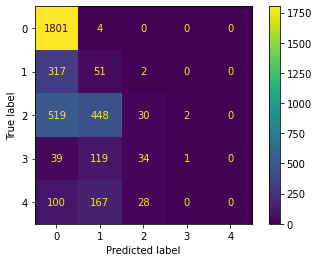

Results for efficientnet-b4




<Figure size 432x288 with 0 Axes>

In [ ]:
def main():
    training_dataset = Dataset_Function(
        directory="/content/drive/MyDrive/2015_resized/train_resized_150",
        csv_file_loc="/content/drive/MyDrive/2015_resized/trainLabels.csv",
        transform=validation_transforms,
    )
    
    train_loader = DataLoader(
        training_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=False,
    )

    validation_dataset = Dataset_Function(
      directory="/content/drive/MyDrive/aptos_resized_150x150/train_images_resized_150",
      csv_file_loc="/content/drive/MyDrive/aptos_resized_150x150/train.csv",
      transform=validation_transforms,
    )  

    validation_loader = DataLoader(
        validation_dataset,
        batch_size=BATCH_SIZE,
        num_workers=1,
        pin_memory=PIN_MEMORY,
        shuffle=False,
    )



    loss_fn = nn.MSELoss()

    model = EfficientNet.from_pretrained("efficientnet-b2")
    model._fc = nn.Linear(1408, 1)
    model = model.to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scaler = torch.cuda.amp.GradScaler()
    for epoch in range(NUM_EPOCHS):
        epoch_wise_train_function(train_loader, model, optimizer, loss_fn, scaler, DEVICE)

        preds, labels = accuracy_function(validation_loader, model, DEVICE)

    print("Results for efficientnet-b2")
    print()
    print()

    model = EfficientNet.from_pretrained("efficientnet-b3")
    model._fc = nn.Linear(1536, 1)
    model = model.to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(NUM_EPOCHS):
        epoch_wise_train_function(train_loader, model, optimizer, loss_fn, scaler, DEVICE)

        predictions, labels = accuracy_function(validation_loader, model, DEVICE)

    print()
    print()

    model = EfficientNet.from_pretrained("efficientnet-b4")
    model._fc = nn.Linear(1792, 1)
    model = model.to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(NUM_EPOCHS):
        epoch_wise_train_function(train_loader, model, optimizer, loss_fn, scaler, DEVICE)

        predictions, labels = accuracy_function(validation_loader, model, DEVICE)

    print("Results for efficientnet-b4")
    print()
    print()

main()
